In [1]:
import tensorflow as tf
import numpy as np
import glob
import os
import re
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def plotPoke(x):
    f, a = plt.subplots(2, 8, figsize=(13, 3))
    for i in range(8):
        a[0][i].imshow(x[i], cmap=plt.get_cmap('gray'))
        a[0,i].axis('off')
        a[1][i].imshow(x[i+8], cmap=plt.get_cmap('gray'))
        a[1,i].axis('off')
    f.show()
    plt.draw()

Input data shape: (792, 40, 40, 3)


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


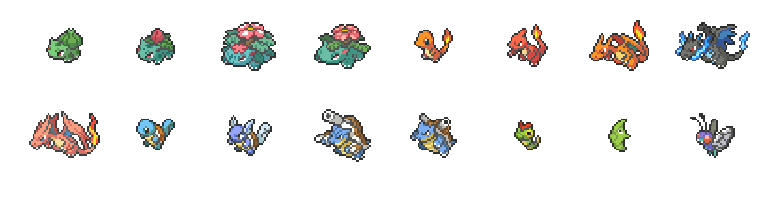

In [3]:
# Create an empty array to store pokemon pics
orig_img = np.empty((0, 40, 40, 3), dtype='float32')
# Load all images and append into orig_img
path = os.path.abspath("./AE_RGB.ipynb")
path = re.sub('[a-zA-Z\s._]+$', '', path)
for pic in glob.glob(path+'Pokemon/*.png'):
    img = mpimg.imread(pic)
    # remove alpha channel  %some alpha=0 but RGB is not equal to [1., 1., 1.]
    img[img[:,:,3]==0] = np.ones((1,4))
    img = img[:,:,0:3]
    orig_img = np.append(orig_img, [img], axis=0)

# Use plt to show original images 
print 'Input data shape: {}'.format(orig_img.shape)
plotPoke(orig_img)

In [4]:
# Parameters
learning_rate = 0.0002
training_epochs = 100
batch_size = 24
display_step = 10
examples_to_show = 8

# Network Parameters
n_input = [40, 40, 3] # Pokemon data input (img shape: 40*40*3)
n_channel1 = 16
n_channel2 = 32
n_channel3 = 64
gen_dim = 500

In [5]:
# tf Graph input
X = tf.placeholder(tf.float32, [None]+n_input)
Z = tf.placeholder(tf.float32, [None, gen_dim])

In [6]:
# Store layers weights & biases
weights = {
    'dis_h1': tf.Variable(tf.truncated_normal([5, 5, 3, n_channel1], stddev=0.01)),
    'dis_h2': tf.Variable(tf.truncated_normal([5, 5, n_channel1, n_channel2], stddev=0.01)),
    'dis_h3': tf.Variable(tf.truncated_normal([5, 5, n_channel2, n_channel3], stddev=0.01)),
    'dis_h4': tf.Variable(tf.truncated_normal([5*5*n_channel3, 1], stddev=0.01)),

    'gen_h1': tf.Variable(tf.truncated_normal([gen_dim, 5*5*n_channel3], stddev=0.01)),
    'gen_h2': tf.Variable(tf.truncated_normal([5, 5, n_channel2, n_channel3], stddev=0.01)),
    'gen_h3': tf.Variable(tf.truncated_normal([5, 5, n_channel1, n_channel2], stddev=0.01)),
    'gen_h4': tf.Variable(tf.truncated_normal([5, 5, 3, n_channel1], stddev=0.01))
}

biases = {
    'dis_h1': tf.Variable(tf.truncated_normal([n_channel1], stddev=0.01)),
    'dis_h2': tf.Variable(tf.truncated_normal([n_channel2], stddev=0.01)),
    'dis_h3': tf.Variable(tf.truncated_normal([n_channel3], stddev=0.01)),
    'dis_h4': tf.Variable(tf.truncated_normal([1], stddev=0.01)),
    
    'gen_h1': tf.Variable(tf.truncated_normal([5*5*n_channel3], stddev=0.01)),
    'gen_h2': tf.Variable(tf.truncated_normal([n_channel2], stddev=0.01)),
    'gen_h3': tf.Variable(tf.truncated_normal([n_channel1], stddev=0.01)),
    'gen_h4': tf.Variable(tf.truncated_normal([3], stddev=0.01))
}

In [7]:
def conv2d(x, W, b, strides=2):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    return tf.nn.bias_add(x, b)

def deconv2d(x, W, b, out_shape, strides=2):
    x = tf.nn.conv2d_transpose(x, W, out_shape, strides=[1, strides, strides, 1], 
                               padding='SAME')
    return tf.nn.bias_add(x, b)

def project(x, W, b):
    return tf.add(tf.matmul(x, W), b)

# Define leaky rectified linear unit (ReLu)
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [8]:
def generator(z):
    hidden_g1 = project(z, weights['gen_h1'], biases['gen_h1'])
    hidden_g1 = tf.reshape(hidden_g1, [-1, 5, 5, n_channel3])
    
    output_dim2 = tf.stack([tf.shape(z)[0], 10, 10, n_channel2])
    hidden_g2 = tf.nn.relu(deconv2d(hidden_g1, weights['gen_h2'], biases['gen_h2'], output_dim2))
    
    output_dim3 = tf.stack([tf.shape(z)[0], 20, 20, n_channel1])
    hidden_g3 = tf.nn.relu(deconv2d(hidden_g2, weights['gen_h3'], biases['gen_h3'], output_dim3))
    
    output_dim4 = tf.stack([tf.shape(z)[0], 40, 40, 3])
    hidden_g4 = tf.nn.tanh(deconv2d(hidden_g3, weights['gen_h4'], biases['gen_h4'], output_dim4))
    return hidden_g4

def discriminator(x):
    hidden_d1 = lrelu(conv2d(x, weights['dis_h1'], biases['dis_h1']))
    hidden_d2 = lrelu(conv2d(hidden_d1, weights['dis_h2'], biases['dis_h2']))
    hidden_d3 = lrelu(conv2d(hidden_d2, weights['dis_h3'], biases['dis_h3']))
    hidden_d3 = tf.reshape(hidden_d3, [-1, 5*5*n_channel3])
    
    hidden_d4 = project(hidden_d3, weights["dis_h4"], biases['dis_h4'])
    return tf.nn.sigmoid(hidden_d3), hidden_d3

In [ ]:
# Construct discriminator and generator
gen_sample = generator(Z)
dis_real, dis_logits = discriminator(X)
dis_fake, dis_logits_ = discriminator(gen_sample)

# Define loss
dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=dis_logits, targets=tf.ones_like(dis_real)))
dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=dis_logits_, targets=tf.zeros_like(dis_fake)))
dis_loss = dis_loss_real+dis_loss_fake
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=dis_logits_, targets=tf.ones_like(dis_fake)))

# Optimizer for discriminator
var_dis = [weights[i] for i in weights if re.match('dis', i)]+[biases[i] for i in biases if re.match('dis', i)]
dis_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(dis_loss, var_list= var_dis)
# Optimizer for generator parameters
var_gen = [weights[i] for i in weights if re.match('gen', i)]+[biases[i] for i in biases if re.match('gen', i)]
gen_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(gen_loss, var_list= var_gen)

In [12]:
# Construct discriminator and generator
gen_sample = generator(Z)
_, dis_real = discriminator(X)
_, dis_fake = discriminator(gen_sample)

# Wasserstein GAN loss
dis_loss = tf.reduce_mean(dis_real) - tf.reduce_mean(dis_fake)
gen_loss = -tf.reduce_mean(dis_fake)

# Optimizer for discriminator
var_dis = [weights[i] for i in weights if re.match('dis', i)]+[biases[i] for i in biases if re.match('dis', i)]
clip_dis = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in var_dis]
dis_optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(-dis_loss, var_list= var_dis)
# Optimizer for generator parameters
var_gen = [weights[i] for i in weights if re.match('gen', i)]+[biases[i] for i in biases if re.match('gen', i)]
gen_optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(gen_loss, var_list= var_gen)

In [27]:
# Initializing the variables
init = tf.global_variables_initializer()

# Create session and graph, initial variables
sess = tf.InteractiveSession()
sess.run(init)

In [28]:
# Load previous trained model and rewrite to variables, if exists
# Before run this cell, you have to run the cell above first, to define variables and init it.
weightSaver = tf.train.Saver(var_list=weights)
biaseSaver = tf.train.Saver(var_list=biases)

weightSaver.restore(sess, "./saved_model/DCGAN_weights.ckpt")
biaseSaver.restore(sess, "./saved_model/DCGAN_biases.ckpt")

print "Model restored."

Model restored.


In [45]:
total_batch = int(orig_img.shape[0]/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    start = 0; end = batch_size
    for i in range(total_batch-1):
        index = np.arange(start, end)
        np.random.shuffle(index)
        batch_xs = orig_img[index]
        batch_zs = sample_Z(batch_size, gen_dim)
        # Run optimization op (backprop) and loss op (to get loss value)
        _, d_loss_train, _ = sess.run([dis_optimizer, dis_loss, clip_dis], feed_dict = {X: batch_xs, Z: batch_zs})
        _, g_loss_train = sess.run([gen_optimizer, gen_loss], feed_dict = {Z: batch_zs})
        start = end; end = start+batch_size
    # Display logs per epoch step
    if ((epoch == 0) or (epoch+1) % display_step == 0) or ((epoch+1) == training_epochs):
        print 'Epoch: {0:04d}   Discriminator loss: {1:f}   Generator loss: {2:f}'.format(epoch+1, d_loss_train, g_loss_train)

print("Optimization Finished!")

Epoch: 0001   Discriminator loss: 0.000467   Generator loss: 0.009599
Epoch: 0010   Discriminator loss: -0.003742   Generator loss: -0.074406
Epoch: 0020   Discriminator loss: -0.000334   Generator loss: 0.080790
Epoch: 0030   Discriminator loss: -0.000110   Generator loss: 0.016612
Epoch: 0040   Discriminator loss: 0.001561   Generator loss: 0.118667
Epoch: 0050   Discriminator loss: -0.001072   Generator loss: 0.057731
Epoch: 0060   Discriminator loss: -0.021503   Generator loss: -0.278770
Epoch: 0070   Discriminator loss: 0.002624   Generator loss: 0.097195
Epoch: 0080   Discriminator loss: -0.027074   Generator loss: -0.500076
Epoch: 0090   Discriminator loss: -0.002724   Generator loss: 0.093675
Epoch: 0100   Discriminator loss: -0.002011   Generator loss: -0.241644
Optimization Finished!


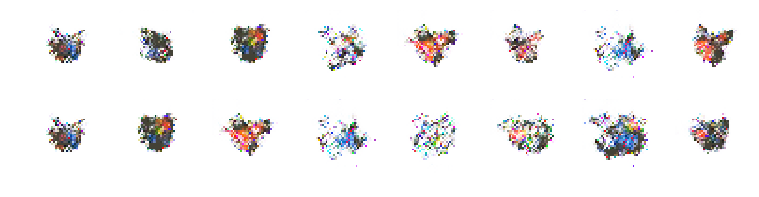

In [46]:
# Let's GENERATE Pokemon !!!!
DCWGAN = sess.run(
    gen_sample, feed_dict={Z: sample_Z(examples_to_show*2, gen_dim)})

# Compare original images with their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(13, 3))
for i in range(examples_to_show):
    a[0][i].imshow(DCWGAN[i])
    a[0,i].axis('off')
    a[1][i].imshow(DCWGAN[i*2])
    a[1,i].axis('off')
f.show()
plt.draw()

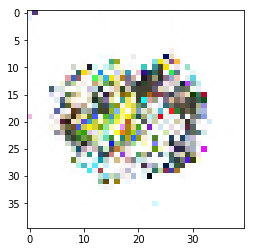

In [56]:
newPok = sess.run(
    gen_sample, feed_dict={Z: sample_Z(1, gen_dim)})
plt.imshow(newPok[0])

In [ ]:
# Save trained Variables 
weightSaver = tf.train.Saver(var_list=weights)
biaseSaver = tf.train.Saver(var_list=biases)
save_path = weightSaver.save(sess, "./saved_model/DCGAN_weights.ckpt")
save_path = biaseSaver.save(sess, "./saved_model/DCGAN_biases.ckpt")